In [2]:
cd ..

/data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subhalo_mass_loss_model as SHMLM
import genericio as gio
from tqdm import tqdm
from itk import hist, h5_read_dict, gio_read_dict, loadpickle, plt_latex, periodic_bcs, many_to_one
from plot_subhalo_mass_fn import CMF, SHMF, plotCMF, plotSHMF
from __future__ import division

In [4]:
PARTICLES100MASS = 1.148276e11 #h^-1 Msun
BOXSIZE = 256

In [5]:
plt_latex()

## Plot AlphaQ core evolved mass functions are compare with AlphaQ subhalo mass function and mass functions from 2016b Figure 5

In [6]:
# Load 2016b Figure 5 plots
fig5a = loadpickle("Notebooks/2016b_fig5a.p") #[12,12.5]
fig5b = loadpickle("Notebooks/2016b_fig5b.p") #[13,13.5]
fig5c = loadpickle("Notebooks/2016b_fig5c.p") #[14,14.5]
fig5 = {12:fig5a, 13:fig5b, 14:fig5c}

In [7]:
def fig5_plot(M1):
    """Plot 2016B Figure 5 plot of M range [M1, M1+0.5]."""
    plotsd = fig5[np.log10(M1)]
    for k in plotsd.keys():
        plt.plot(plotsd[k][:,0][np.argsort(plotsd[k][:,1])], plotsd[k][:,1][np.argsort(plotsd[k][:,1])], '-', label=k, alpha=0.7)

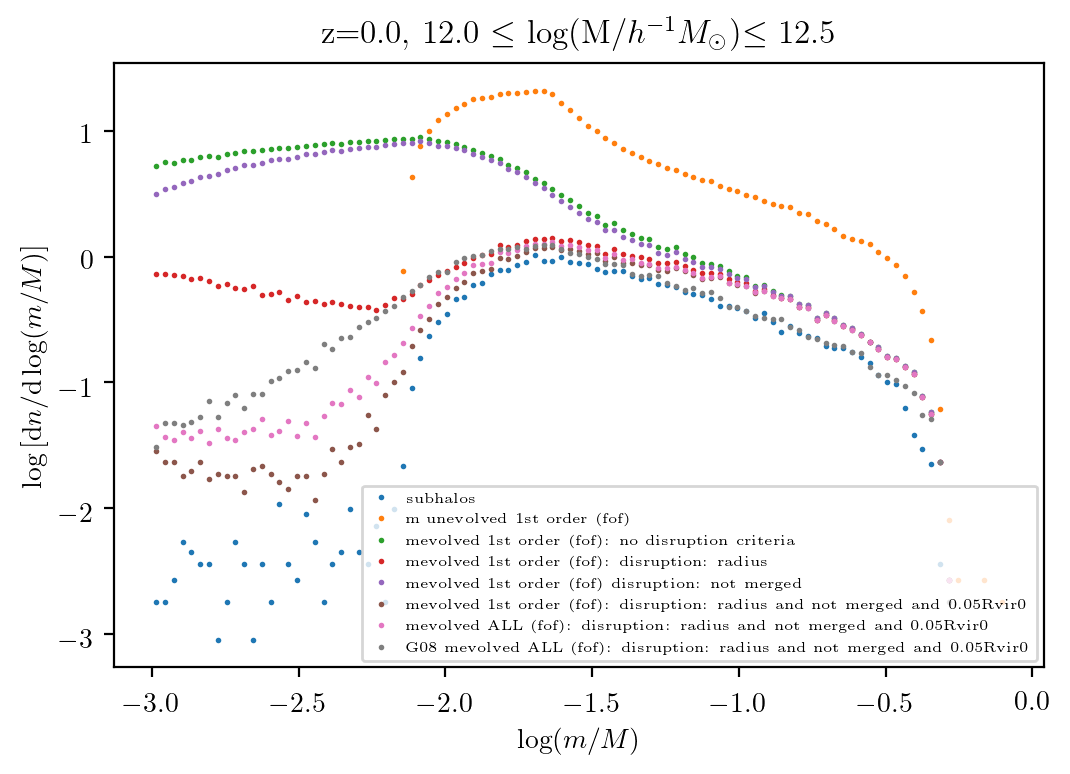

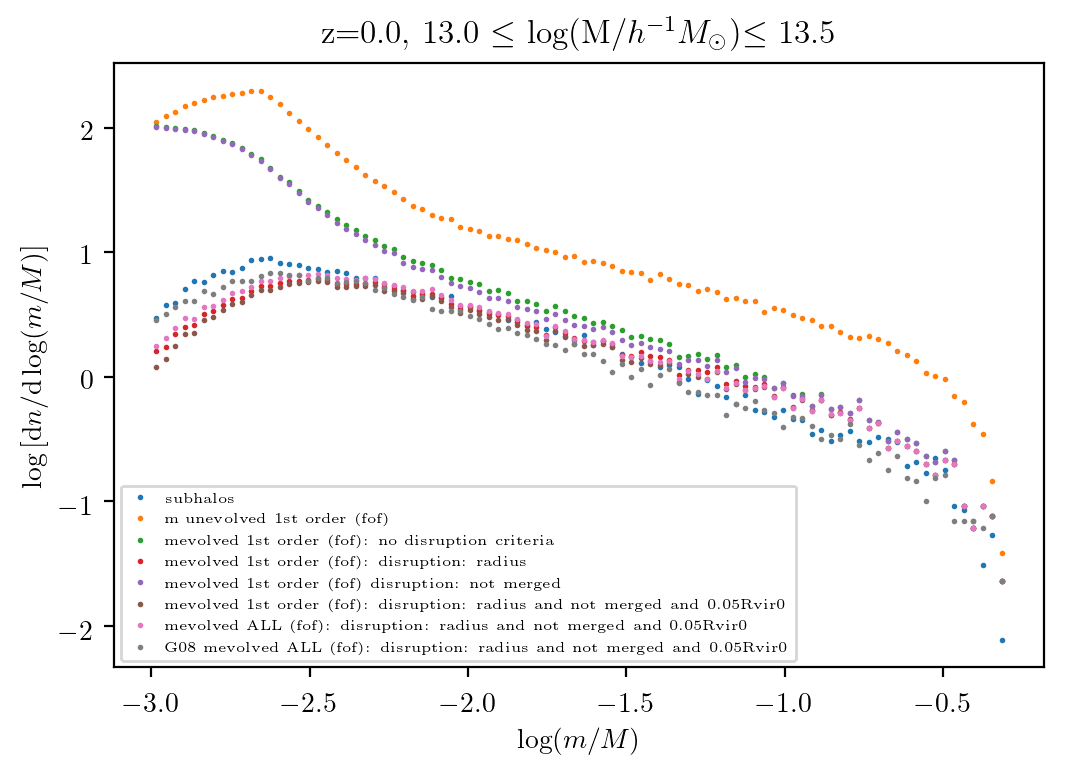

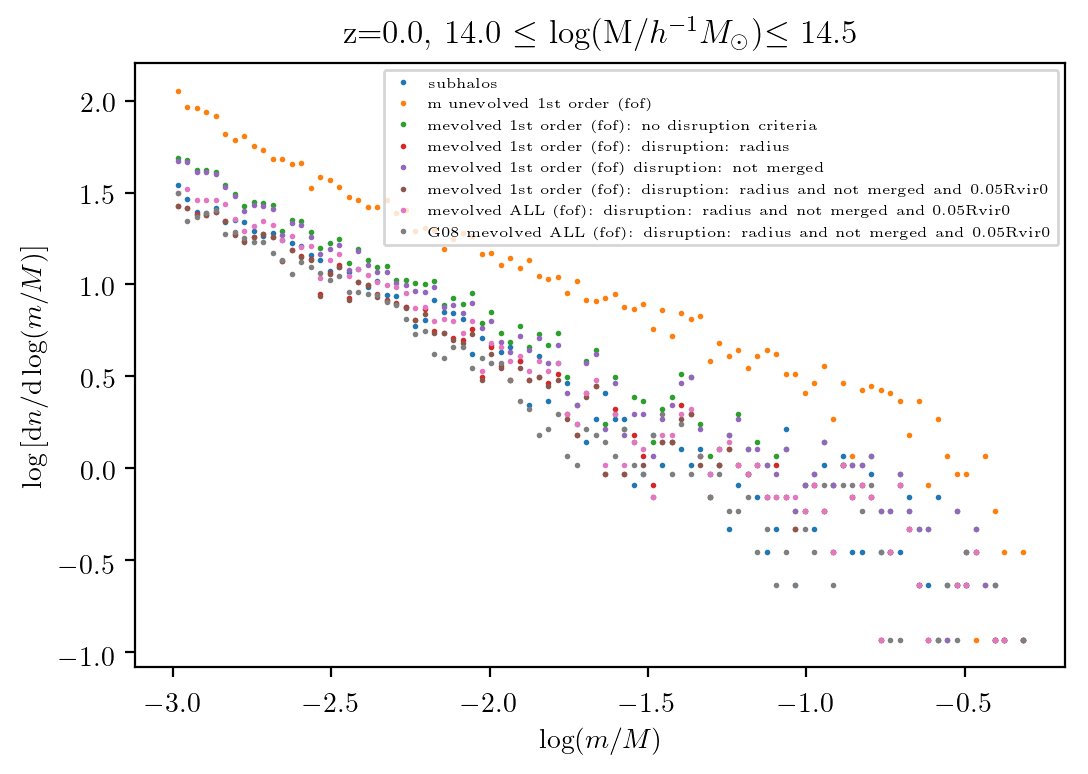

In [13]:
step=499
rall = {12:-4,13:-5,14:-6}
for M1 in [12.,13.,14.]:
#     r = (rall[M1], 0)
    r = (-3,0)
    
    M2 = M1 + 0.5
    M1 = 10**M1
    M2 = 10**M2

    plt.figure(dpi=200)
    plotSHMF(M1, M2, r)
    
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=None, returnUnevolved=True, label='m unevolved 1st order (fof)', r=r)
#     plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=True, label='m unevolved all (fof)', r=r)
    
#     plotCMF('output_merg_virial/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, returnUnevolved=False, label='mevolved 1st order (virial)', r=r)
#     plotCMF('output_merg_virial/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=False, label='mevolved all (virial)', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=None, returnUnevolved=False, label='mevolved 1st order (fof): no disruption criteria', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=1, returnUnevolved=False, label='mevolved 1st order (fof): disruption: radius', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=2, returnUnevolved=False, label='mevolved 1st order (fof) disruption: not merged', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=[1,2,3], returnUnevolved=False, label='mevolved 1st order (fof): disruption: radius and not merged and 0.05Rvir0', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, disrupt=[1,2,3], returnUnevolved=False, label='mevolved ALL (fof): disruption: radius and not merged and 0.05Rvir0', r=r)
    plotCMF('output_merg_fof_G08/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, disrupt=[1,2,3], returnUnevolved=False, label='G08 mevolved ALL (fof): disruption: radius and not merged and 0.05Rvir0', r=r)
#     plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=False, label='mevolved all (fof)', r=r)

#     fig5_plot(M1)

    plt.xlabel(r'$\log(m/M)$')
    plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
    plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );
    plt.legend(prop={'size': 5})
#     plt.savefig('Notebooks/figs/disruptionMF_{}.png'.format(int(np.log10(M1))))

## Visualizations of particular halos: to study effects of core filtering criteria on a case-by-case basis

In [18]:
cols_cc = ['fof_halo_tag', 'x', 'y', 'z', 'radius', 'infall_mass', 'central', 'host_core', 'core_tag', 'merged', 'tree_node_index']

bhp = gio_read_dict('/home/isultan/data/AlphaQ/big_halo_prtcls2/m000-499.bighaloparticles', ['fof_halo_tag', 'x', 'y', 'z'])
sh = gio_read_dict('/home/isultan/data/AlphaQ/subhalos/m000-499.subhaloproperties', ['fof_halo_tag','subhalo_mean_x','subhalo_mean_y','subhalo_mean_z','subhalo_count', 'subhalo_tag', 'subhalo_mass'])
cc = gio_read_dict('/home/isultan/data/AlphaQ/core_catalog_merg/09_03_2019.AQ.499.coreproperties', cols_cc)
mt = gio_read_dict('/home/isultan/data/AlphaQ/updated_tree_nodes/09_03_2019.AQ.499.treenodes', ['fof_halo_tag', 'fof_halo_mass'])

In [16]:
def subhalo_core_plot(fht, saveFlag=False, label='', disrupt=None, s1=False, xlim=None, ylim=None):
    fig=plt.figure(dpi= 120)
    
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim)
    
    cc_halo = { k:cc[k][cc['fof_halo_tag']==fht].copy() for k in cols_cc }
    
    idx_filteredsatcores, M, nHalo = SHMLM.core_mask(cc_halo, 0, 10**16, s1=s1, disrupt=disrupt)
    fhm = M[0]
    
    cc_halo = { k:cc_halo[k][idx_filteredsatcores].copy() for k in ['x', 'y', 'z'] }
    sh_halo = { k:sh[k][(sh['fof_halo_tag']==fht)&(sh['subhalo_tag']!=0)].copy() for k in ['subhalo_mean_x', 'subhalo_mean_y', 'subhalo_mean_z'] }
    bhp_halo = { k:bhp[k][bhp['fof_halo_tag']==fht].copy() for k in ['x', 'y', 'z'] }
    
    if len(cc_halo['x']) > 1:
        x_ref, y_ref = cc_halo['x'][0], cc_halo['y'][0]
        # periodic boundary conditions core mask
        cc_halo['x'] = periodic_bcs(cc_halo['x'], x_ref, BOXSIZE)
        cc_halo['y'] = periodic_bcs(cc_halo['y'], y_ref, BOXSIZE)
        # periodic boundary conditions subhalo mask
        sh_halo['subhalo_mean_x'] = periodic_bcs(sh_halo['subhalo_mean_x'], x_ref, BOXSIZE)
        sh_halo['subhalo_mean_y'] = periodic_bcs(sh_halo['subhalo_mean_y'], y_ref, BOXSIZE)
        # periodic boundary conditions bhp mask
        bhp_halo['x'] = periodic_bcs(bhp_halo['x'], x_ref, BOXSIZE)
        bhp_halo['y'] = periodic_bcs(bhp_halo['y'], y_ref, BOXSIZE)

    counts, xbins, ybins = np.histogram2d(bhp_halo['x'], bhp_halo['y'], bins=100)
    plt.pcolormesh(xbins, ybins, counts.T, cmap='Greys', norm=matplotlib.colors.LogNorm());
    plt.colorbar();

    plt.scatter(cc_halo['x'], cc_halo['y'], s=100, facecolors='none', edgecolors='r', label='Cores')
    plt.scatter(sh_halo['subhalo_mean_x'], sh_halo['subhalo_mean_y'], marker='x', c='b', label='Subhalos');
   
    plt.title(r'z=0, fof halo mass={}, filter {}'.format(np.format_float_scientific(fhm), disrupt))
    plt.xlabel('x [$\mathrm{h^{-1}\ Mpc}$]')
    plt.ylabel('y [$\mathrm{h^{-1}\ Mpc}$]')
    plt.legend(loc=0);
    if saveFlag:
        plt.savefig('Notebooks/figs/figure{}.png'.format(fht))
        plt.close(fig)
    return plt.xlim(), plt.ylim()

In [18]:
def visdisruption(fht):
    xlim, ylim = subhalo_core_plot(fht, saveFlag=False, disrupt=None, s1=False)
    subhalo_core_plot(fht, saveFlag=False, disrupt=None, s1=True, xlim=xlim, ylim=ylim)
    subhalo_core_plot(fht, saveFlag=False, disrupt=1, s1=True, xlim=xlim, ylim=ylim)
    subhalo_core_plot(fht, saveFlag=False, disrupt=2, s1=True, xlim=xlim, ylim=ylim)
    subhalo_core_plot(fht, saveFlag=False, disrupt=3, s1=True, xlim=xlim, ylim=ylim)
    subhalo_core_plot(fht, saveFlag=False, disrupt=[1,2,3], s1=True, xlim=xlim, ylim=ylim)
    subhalo_core_plot(fht, saveFlag=False, disrupt=3, s1=False, xlim=xlim, ylim=ylim)

In [26]:
M1, M2 = 10**13, 10**14
np.random.choice( cc['fof_halo_tag'][(cc['central']==1)&(M1<=cc['infall_mass'])&(cc['infall_mass']<=M2)], 5 )

array([739698872, 873213707, 918135106, 964237199, 691697733])

In [ ]:
# 12 tags
M1, M2 = 10**12, 10**13.5
for fht in sorted(np.random.choice( cc['fof_halo_tag'][(cc['central']==1)&(M1<=cc['infall_mass'])&(cc['infall_mass']<=M2)], 5 )):
    visdisruption(fht)

In [ ]:
# 12 tags
for fht in np.sort([1011920733, 393631551, 1067579619, 115756539, 238720784, 297643316, 429364955, 461607419, 464813881, 673244686, 742961773, 785424584, 807348995])[:1]:
    visdisruption(fht)

In [ ]:
# 13 tags
for fht in sorted([1002483900, 135214525, 151409309, 238061426, 241511998, 288394524, 334773736, 501768777, 814229370, 816551969])[:1]:
    visdisruption(fht)

In [ ]:
# 14 tags
for fht in sorted([1040287332,  757527166,  472937720,  802574311,  621261511,38685933,  112886331,  141272803,  245352048,  182027995])[:1]:
    visdisruption(fht)

## Subhalo-core matching: to look at the subhalo mass:core evolved mass ratio

In [19]:
from scipy import spatial #KD Tree for subhalo-core matching
def generate_cores_kdtree(M1, M2, s1=False, disrupt=None, fn='/home/isultan/projects/halomassloss/core_catalog_mevolved/output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5'):
    cc = h5_read_dict(fn, 'coredata')
    idx_filteredsatcores, _, _ = SHMLM.core_mask(cc, M1, M2, s1=s1, disrupt=disrupt)
    return spatial.cKDTree( np.vstack((cc['x'][idx_filteredsatcores], cc['y'][idx_filteredsatcores], cc['z'][idx_filteredsatcores])).T ), { k:cc[k][idx_filteredsatcores].copy() for k in cc.keys() }

In [27]:
M1, M2 = 10**13., 10**14.
cores_tree, cc_filtered = generate_cores_kdtree(M1=M1, M2=M2, s1=False, disrupt=None) #add 3 mass bins for M

In [28]:
sh['rvir_0'] = SHMLM.getRvir_0(sh['subhalo_mass'])

idx_m21_sh = many_to_one(sh['fof_halo_tag'], mt['fof_halo_tag'])
sh['M'] = mt['fof_halo_mass'][idx_m21_sh]
sh_mask = (sh['subhalo_tag']!=0)&(M1<=sh['M'])&(sh['M']<=M2)

sh_arr = np.vstack((sh['subhalo_mean_x'][sh_mask], sh['subhalo_mean_y'][sh_mask], sh['subhalo_mean_z'][sh_mask])).T
distance_upper_bound = 2 * sh['rvir_0'][sh_mask]

### Fixed search radius of 0.1 Mpc/h to search for cores around each subhalo, only look for 1:1 matches

In [24]:
dist, idx = cores_tree.query(sh_arr, k=2, distance_upper_bound=0.1)

In [25]:
f1, f2 = (dist != np.inf).T
fmask = f1^f2

In [2]:
def plotMatchHist():
    plt.hist(sh['subhalo_mass'][sh_mask][fmask] / cc_filtered['infall_mass'][idx[:,0][fmask]], range=(0,4), bins=100);
    plt.hist(sh['subhalo_mass'][sh_mask][fmask] / cc_filtered['m_evolved'][idx[:,0][fmask]], range=(0,4), bins=100, alpha=.5);
    plt.axvline(x=1, c='y')
    plt.title( 'z=0, {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) )

    percentmatch = np.sum(fmask)/np.sum(sh_mask)*100
    f1i = f1[np.invert(fmask)]
    percentmany = np.sum(f1i)/len(f1i)*100
    percentnone = np.sum(np.invert(f1i))/len(f1i)*100
    print '{}% of masked subhalos have 1:1 core match. Of the unmatched subhalos, {}% have mutliple cores and {}% have no core.'.format(percentmatch, percentmany, percentnone)

### Search radius of 2*rvir0 around each subhalo, only look for 1:1 matches

In [29]:
dist, idx = [], []
for i in tqdm(range(len(distance_upper_bound))):
    dv, iv = cores_tree.query(sh_arr[i], k=2, distance_upper_bound=distance_upper_bound[i])
    dist.append(dv)
    idx.append(iv)
dist = np.array(dist)
idx = np.array(idx)

100%|██████████| 64896/64896 [00:01<00:00, 32451.38it/s]


In [30]:
f1, f2 = (dist != np.inf).T
fmask = f1^f2

13.3151503945% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 99.7493556128% have mutliple cores and 0.250644387166% have no core.


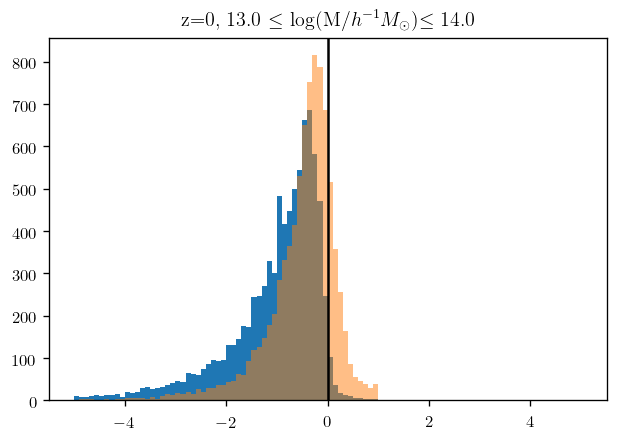

In [31]:
plt.hist((sh['subhalo_mass'][sh_mask][fmask] - cc_filtered['infall_mass'][idx[:,0][fmask]])/sh['subhalo_mass'][sh_mask][fmask], range=(-5,5), bins=100);
plt.hist((sh['subhalo_mass'][sh_mask][fmask] - cc_filtered['m_evolved'][idx[:,0][fmask]])/sh['subhalo_mass'][sh_mask][fmask], range=(-5,5), bins=100, alpha=.5);
plt.axvline(x=0, c='k')
plt.title( 'z=0, {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) )

percentmatch = np.sum(fmask)/np.sum(sh_mask)*100
f1i = f1[np.invert(fmask)]
percentmany = np.sum(f1i)/len(f1i)*100
percentnone = np.sum(np.invert(f1i))/len(f1i)*100
print '{}% of masked subhalos have 1:1 core match. Of the unmatched subhalos, {}% have mutliple cores and {}% have no core.'.format(percentmatch, percentmany, percentnone)

### 2*rvir0 search radius, select most massive core for 1:1 match

In [55]:
iarr, carr = [], []
for i in tqdm(range(len(distance_upper_bound))):
    qres = cores_tree.query_ball_point(sh_arr[i], r=distance_upper_bound[i])
    if len(qres)>0:
        idxmax = qres[ np.argmax(cc_filtered['m_evolved'][qres]) ]
        iarr.append(i)
        carr.append(idxmax)

100%|██████████| 25834/25834 [00:00<00:00, 71058.80it/s]


In [3]:
def plotMatchHistMostMassive():
    plt.hist(sh['subhalo_mass'][sh_mask][iarr] / cc_filtered['infall_mass'][carr], range=(0,4), bins=100);
    plt.hist(sh['subhalo_mass'][sh_mask][iarr] / cc_filtered['m_evolved'][carr], range=(0,4), bins=100, alpha=.5);
    plt.axvline(x=1, c='k')
    plt.title( 'z=0, {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) )

    percentexists = len(iarr)/np.sum(sh_mask)*100
    print '{}% of masked subhalos have at least 1 core within their search radius.'.format(percentexists)